https://github.com/Eligijus112/Vilnius-weather-LSTM/blob/main/weather-analysis.ipynb

https://towardsdatascience.com/predictive-analytics-time-series-forecasting-with-gru-and-bilstm-in-tensorflow-87588c852915

https://towardsdatascience.com/single-and-multi-step-temperature-time-series-forecasting-for-vilnius-using-lstm-deep-learning-b9719a0009de

In [ ]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Date wrangling
import datetime

# Math operations
import numpy as np

# Random sampling
import random

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

In [ ]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y


In [ ]:
d = pd.read_csv('/content/drive/MyDrive/fei/DP/data/final_dfs/3_years_MARS.csv')
print(f'Shape of data: {d.shape}')

Shape of data: (1338, 17)


In [ ]:
d = d.apply(pd.to_numeric, errors='coerce')
d.info()

d.drop(['SOL_CHRONOLOGICAL','EARTH_DATE','SOL_NUMBER','MARTIAN_MONTH','MARS_YEAR','YEAR_SOL','SOL_IN_MONTH'], axis=1, inplace=True)

Q1 = d.quantile(0.25)
Q3 = d.quantile(0.75)
IQR = Q3 - Q1

d = d[~((d < (Q1 - 1.5 * IQR)) |(d > (Q3 + 1.5 * IQR))).any(axis=1)]

d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   #                  1338 non-null   int64  
 1   SOL_CHRONOLOGICAL  1338 non-null   int64  
 2   EARTH_DATE         0 non-null      float64
 3   LS                 1338 non-null   float64
 4   SOL_NUMBER         1338 non-null   int64  
 5   MARTIAN_MONTH      1338 non-null   int64  
 6   MARS_YEAR          1338 non-null   int64  
 7   T_min              1338 non-null   float64
 8   T_max              1338 non-null   float64
 9   P_min              1338 non-null   float64
 10  P_max              1338 non-null   float64
 11  VMR_min            1338 non-null   float64
 12  VMR_max            1338 non-null   float64
 13  RH_min             1338 non-null   float64
 14  RH_max             1338 non-null   float64
 15  YEAR_SOL           1338 non-null   int64  
 16  SOL_IN_MONTH       1338 

In [ ]:
# Types of columns
d.dtypes

#            int64
LS         float64
T_min      float64
T_max      float64
P_min      float64
P_max      float64
VMR_min    float64
VMR_max    float64
RH_min     float64
RH_max     float64
dtype: object

Column explanations
The columns that will be used in the analysis:

dt - local datetime of the observation - #

date - local date of the observation - LS

temp - the observed temperature in Celcius - T_max

pressure - Atmospheric pressure (on the sea level, if there is no sea_level or grnd_level data), hPa - P_max

clouds_all - cloudiness in %.

wind_speed - speed of wind in meter/sec.

humidity - concentrantion of water vapor in the air.

In [ ]:
print(f"Total unique dates in the dataset: {len(set(d['#']))}")

Total unique dates in the dataset: 1297


In [ ]:
print(f"Number of rows in the dataset: {d.shape[0]}")


Number of rows in the dataset: 1297


In [ ]:
d.columns

Index(['#', 'LS', 'T_min', 'T_max', 'P_min', 'P_max', 'VMR_min', 'VMR_max',
       'RH_min', 'RH_max'],
      dtype='object')

In [ ]:
# Features used in models
features = ['T_min', 'T_max', 'P_min', 'P_max', 'VMR_min', 'VMR_max', 'RH_min', 'RH_max']

# Aggregating to hourly level
d = d.groupby('#', as_index=False)[features].mean()

# Creating the data column
d['date'] = [x for x in d['#']]

In [ ]:
d[features].describe()

,T_min,T_max,P_min,P_max,VMR_min,VMR_max,RH_min,RH_max
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,195.667695,259.458188,796.078604,878.411218,24.781257,3422.874109,0.844688,20.903123
std,5.779356,10.973176,53.440491,55.202718,9.490640,1860.639532,0.300940,10.408099
min,178.760000,225.850000,686.240000,760.090000,6.130000,532.930000,0.290000,1.870000
25%,191.570000,249.160000,762.610000,833.460000,16.640000,1753.880000,0.590000,12.550000
50%,196.250000,260.100000,805.920000,892.050000,25.900000,3116.420000,0.810000,18.110000
75%,200.020000,268.440000,842.050000,922.030000,31.790000,4750.140000,1.080000,26.960000
max,209.240000,285.810000,921.390000,966.110000,49.930000,9183.450000,1.800000,50.250000


In [ ]:
d[['#', 'T_max']].head(10)

,#,T_max
0,1,260.72
1,2,264.51
2,3,264.48
3,4,263.51
4,5,263.65
5,6,261.85
6,7,264.33
7,8,264.83
8,9,264.28
9,10,264.89


In [ ]:
d[['#', 'T_max']].tail(10)

,#,T_max
1287,1328,248.76
1288,1329,246.11
1289,1330,246.66
1290,1331,248.41
1291,1332,248.72
1292,1333,246.57
1293,1334,247.75
1294,1335,255.04
1295,1336,249.25
1296,1337,246.78


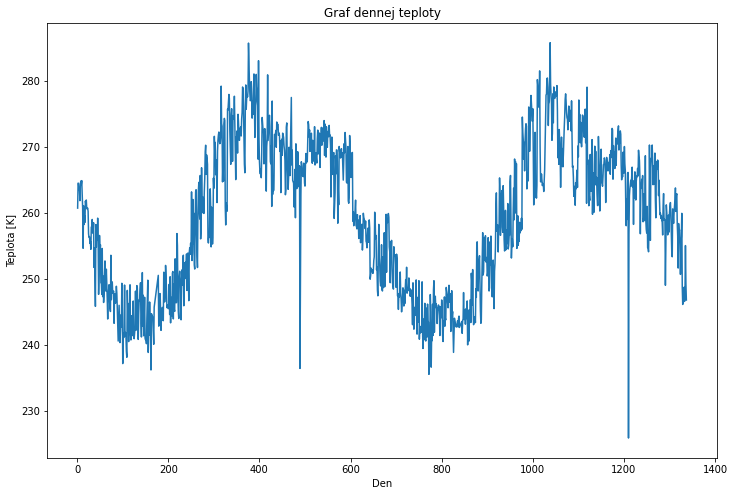

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot('#', 'T_max', data=d)
plt.title('Graf dennej teploty')
plt.ylabel('Teplota [K]')
plt.xlabel('Den')
plt.show()


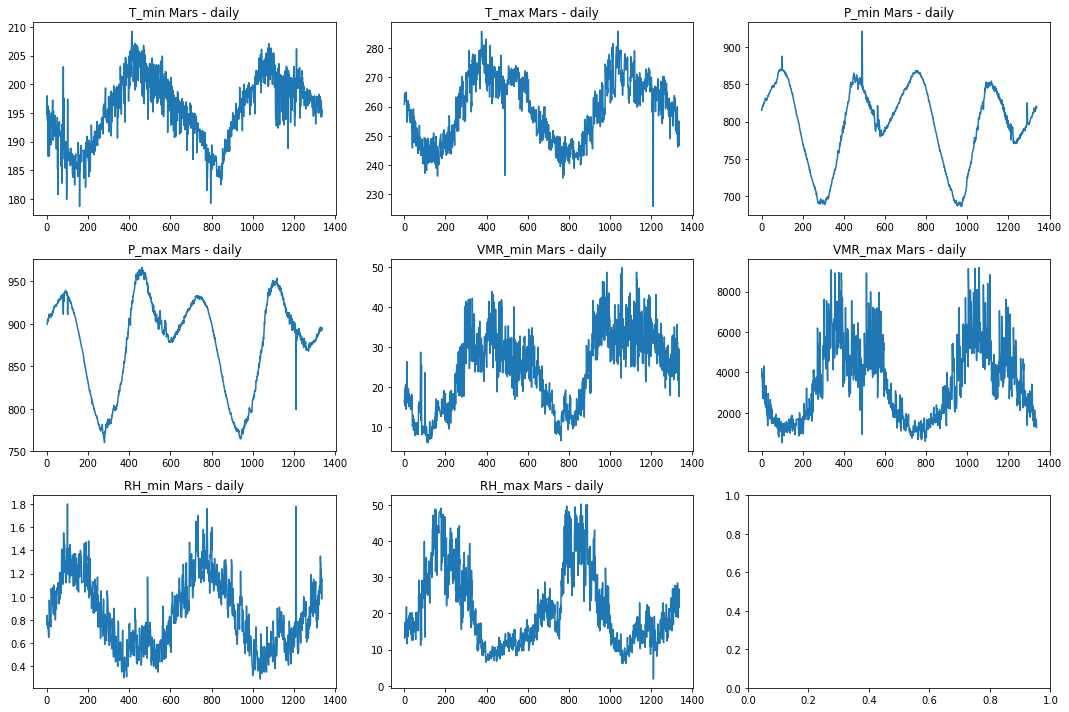

In [ ]:
plot_features = d.groupby('date')[features].mean()

fig, axes = plt.subplots(
    nrows=3, 
    ncols=3, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(features):
    axes[i // 3, i % 3].plot(plot_features[feature])
    axes[i // 3, i % 3].set_title(f'{feature} Mars - daily')
        
plt.tight_layout()

plt.show()


In [ ]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer, metrics=['MeanSquaredError', 'MeanAbsoluteError', 'RootMeanSquaredError'])

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [ ]:
# Number of lags (days back) to use for models
lag = 7

# Steps ahead to forecast 
n_ahead = 1

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 100

# Batch size 
batch_size = 32

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 100

# The features used in the modeling 
features_final = ['T_min', 'T_max', 'P_min', 'P_max', 'VMR_min', 'VMR_max', 'RH_min', 'RH_max']

In [ ]:
# Subseting only the needed columns 
ts = d[features_final]

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]

# Scaling the data 
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame 
ts_s = pd.concat([train, test])

In [ ]:
d[features_final].head(10)

,T_min,T_max,P_min,P_max,VMR_min,VMR_max,RH_min,RH_max
0,194.73,260.72,815.12,899.48,16.71,4180.42,0.76,13.23
1,197.98,264.51,816.85,901.16,16.06,3774.17,0.84,13.42
2,193.67,264.48,819.01,901.86,19.36,3999.05,0.75,15.87
3,196.25,263.51,819.41,905.63,15.95,3736.48,0.73,16.90
4,195.54,263.65,820.17,903.65,15.33,3303.18,0.73,17.57
5,188.56,261.85,820.37,902.56,20.16,2721.30,0.77,13.63
6,187.42,264.33,821.21,903.36,18.21,3013.54,0.70,14.67
7,193.84,264.83,822.33,905.41,14.49,2948.50,0.68,15.04
8,194.51,264.28,820.84,907.55,15.77,3055.46,0.65,17.21
9,195.22,264.89,821.88,911.13,20.82,2701.84,0.69,17.91


In [ ]:
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

In [ ]:
X.shape

(1289, 7, 8)

In [ ]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [ ]:
print(f"Rozmer trénovacích dát: {Xtrain.shape}") # we have X observations each with Y rows of data and Z columns (X,Y,Z) to LSTM
print(f"Rozmer dát cielovej premennej: {Ytrain.shape}")

print(f"Rozmer validačných dát: {Xval.shape}")
print(f"Rozmer dát velidačnej cielovej premennej: {Yval.shape}")


Rozmer trénovacích dát: (1160, 7, 8)
Rozmer dát cielovej premennej: (1160, 1)
Rozmer validačných dát: (129, 7, 8)
Rozmer dát velidačnej cielovej premennej: (129, 1)


In [ ]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)


In [ ]:
model.model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 8)]            0         
                                                                 
 lstm (LSTM)                 (None, 100)               43600     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 43,701
Trainable params: 43,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.train()


Epoch 1/100
37/37 [==============================] - 3s 19ms/step - loss: 0.5938 - mean_squared_error: 0.5726 - mean_absolute_error: 0.5938 - root_mean_squared_error: 0.7567 - val_loss: 0.2610 - val_mean_squared_error: 0.1119 - val_mean_absolute_error: 0.2610 - val_root_mean_squared_error: 0.3345
Epoch 2/100
37/37 [==============================] - 0s 9ms/step - loss: 0.3413 - mean_squared_error: 0.2065 - mean_absolute_error: 0.3413 - root_mean_squared_error: 0.4544 - val_loss: 0.2402 - val_mean_squared_error: 0.0979 - val_mean_absolute_error: 0.2402 - val_root_mean_squared_error: 0.3129
Epoch 3/100
37/37 [==============================] - 0s 10ms/step - loss: 0.3427 - mean_squared_error: 0.2046 - mean_absolute_error: 0.3427 - root_mean_squared_error: 0.4523 - val_loss: 0.2036 - val_mean_squared_error: 0.0765 - val_mean_absolute_error: 0.2036 - val_root_mean_squared_error: 0.2766
Epoch 4/100
37/37 [==============================] - 0s 9ms/step - loss: 0.3326 - mean_squared_error: 0.209

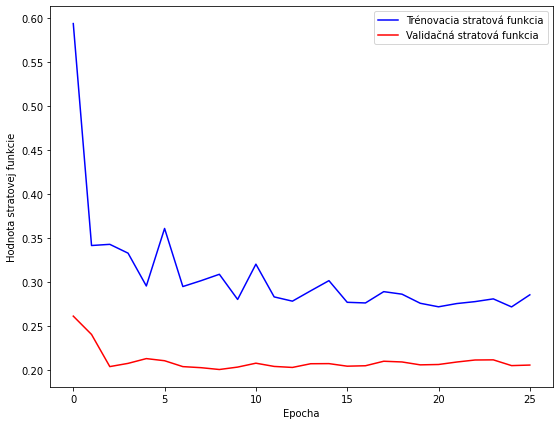

In [ ]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Trénovacia stratová funkcia', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validačná stratová funkcia', color='red')
plt.legend(loc=0)
plt.xlabel('Epocha')
plt.ylabel('Hodnota stratovej funkcie')
plt.show()


In [ ]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

In [ ]:
# Creating the frame to store both predictions
days = d['#'].values[-len(y):]

frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])



In [ ]:
frame

,day,temp,type
0,1207,0.300150,original
1,1208,-0.159949,original
2,1209,0.775252,original
3,1210,0.935286,original
4,1211,0.248472,original
...,...,...,...
124,1333,-0.141385,forecast
125,1334,-0.136208,forecast
126,1335,-0.104548,forecast
127,1336,-0.174929,forecast


In [ ]:
# Creating the unscaled values column
frame['temp_absolute'] = [(x * train_std['T_max']) + train_mean['T_max'] for x in frame['temp']]

# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

In [ ]:
frame

,day,temp,type,temp_absolute
0,1207,0.300150,original,262.782443
1,1208,-0.159949,original,257.550631
2,1209,0.775252,original,268.184859
3,1210,0.935286,original,270.004619
4,1211,0.248472,original,262.194812
...,...,...,...,...
124,1333,-0.141385,forecast,257.761717
125,1334,-0.136208,forecast,257.820583
126,1335,-0.104548,forecast,258.180594
127,1336,-0.174929,forecast,257.380283


In [ ]:
pivoted.tail(10)


,temp_forecast,temp_original,temp_absolute_forecast,temp_absolute_original,res,res_abs
day,,,,,,
1328,0.096373,0.401838,260.465283,263.938750,3.473467,3.473467
1329,0.174730,0.245138,261.356288,262.156901,0.800613,0.800613
1330,0.068204,0.028425,260.144970,259.692641,-0.452329,0.452329
1331,-0.043817,0.176790,258.871170,261.379711,2.508541,2.508541
1332,-0.114460,-0.186621,258.067884,257.247338,-0.820546,0.820546
1333,-0.141385,-0.129942,257.761717,257.891836,0.130119,0.130119
1334,-0.136208,0.296816,257.820583,262.744532,4.923949,4.923949
1335,-0.104548,0.115110,258.180594,260.678345,2.497751,2.497751
1336,-0.174929,-0.054926,257.380283,258.744849,1.364566,1.364566


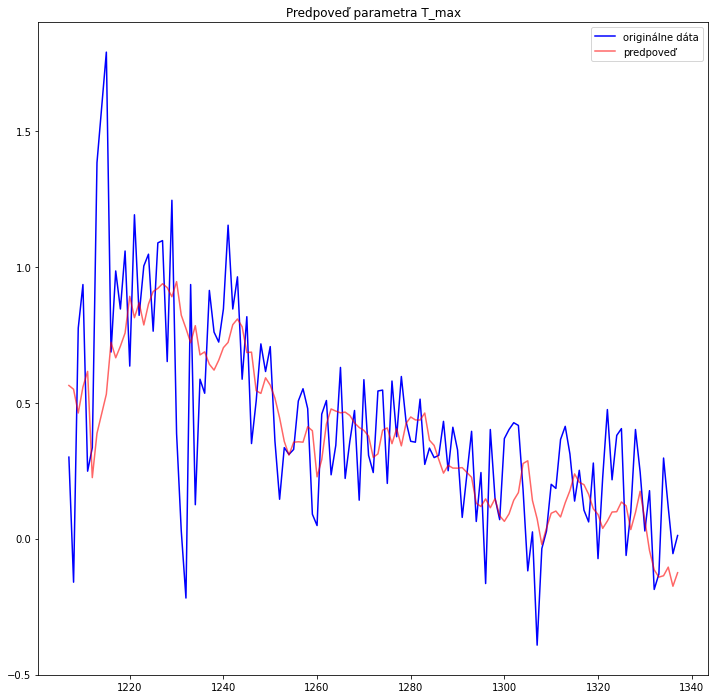

In [ ]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_original, color='blue', label='originálne dáta')
plt.plot(pivoted.index, pivoted.temp_forecast, color='red', label='predpoveď', alpha=0.6)
plt.title('Predpoveď parametra T_max')
plt.legend()
plt.show()

In [ ]:
pivoted.index

Int64Index([1207, 1208, 1209, 1210, 1211, 1212, 1213, 1215, 1216, 1217,
            ...
            1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337],
           dtype='int64', name='day', length=129)

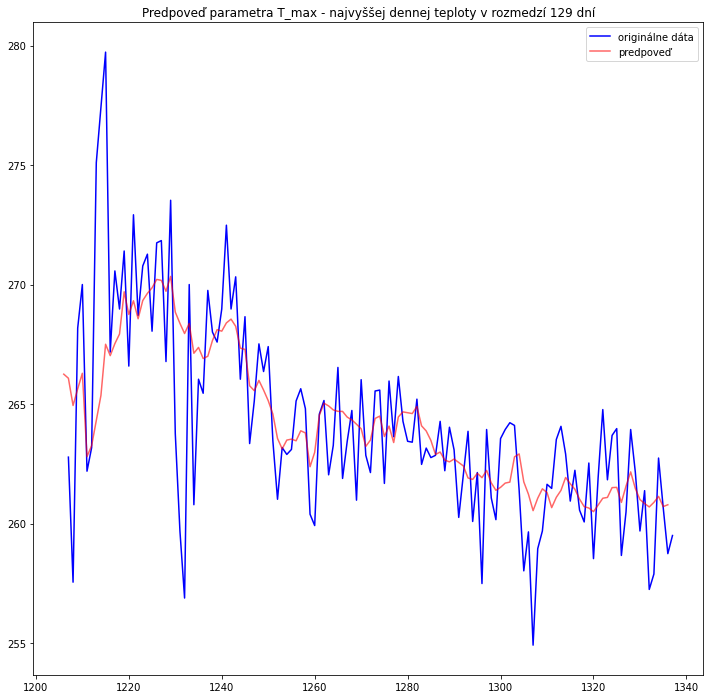

In [ ]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_absolute_original, color='blue', label='originálne dáta')
plt.plot(pivoted.index-1, pivoted.temp_absolute_forecast, color='red', label='predpoveď', alpha=0.6)
plt.title('Predpoveď parametra T_max - najvyššej dennej teploty v rozmedzí 129 dní')
plt.legend()
plt.show()

In [ ]:
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]


In [ ]:
pivoted

,temp_forecast,temp_original,temp_absolute_forecast,temp_absolute_original,res,res_abs
day,,,,,,
1207,0.605463,0.300150,266.254186,262.782443,-3.471742,3.471742
1208,0.590488,-0.159949,266.083900,257.550631,-8.533269,8.533269
1209,0.490267,0.775252,264.944282,268.184859,3.240576,3.240576
1210,0.551505,0.935286,265.640625,270.004619,4.363994,4.363994
1211,0.608726,0.248472,266.291280,262.194812,-4.096468,4.096468
...,...,...,...,...,...,...
1333,0.116856,-0.129942,260.698193,257.891836,-2.806357,2.806357
1334,0.133667,0.296816,260.889351,262.744532,1.855181,1.855181
1335,0.155828,0.115110,261.141343,260.678345,-0.462998,0.462998


In [ ]:
pivoted.tail(10)


,temp_forecast,temp_original,temp_absolute_forecast,temp_absolute_original,res,res_abs
day,,,,,,
1328,0.193549,0.401838,261.570273,263.938750,2.368477,2.368477
1329,0.245871,0.245138,262.165232,262.156901,-0.008332,0.008332
1330,0.184892,0.028425,261.471832,259.692641,-1.779191,1.779191
1331,0.143966,0.176790,261.006461,261.379711,0.373250,0.373250
1332,0.129594,-0.186621,260.843035,257.247338,-3.595697,3.595697
1333,0.116856,-0.129942,260.698193,257.891836,-2.806357,2.806357
1334,0.133667,0.296816,260.889351,262.744532,1.855181,1.855181
1335,0.155828,0.115110,261.141343,260.678345,-0.462998,0.462998
1336,0.118276,-0.054926,260.714341,258.744849,-1.969492,1.969492


In [ ]:
print(f"Average absolute mean error: {round(pivoted['res_abs'].sum() / pivoted.shape[0], 2)} K")


Average absolute mean error: 2.3 K


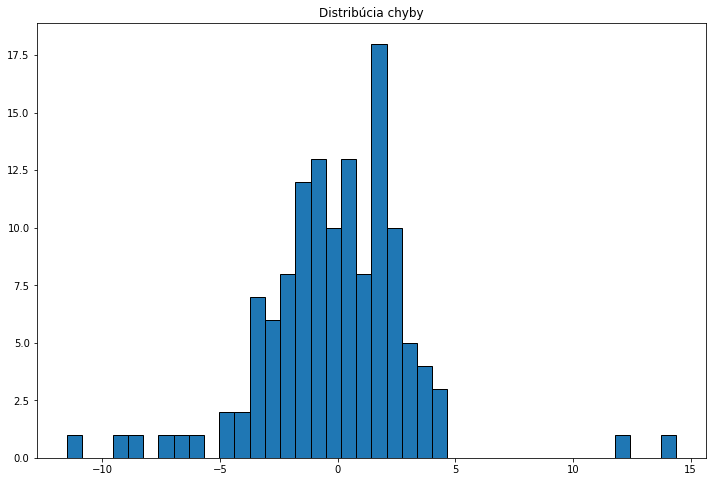

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.res, bins=40, edgecolor='black')
plt.title('Distribúcia chyby')
plt.show()


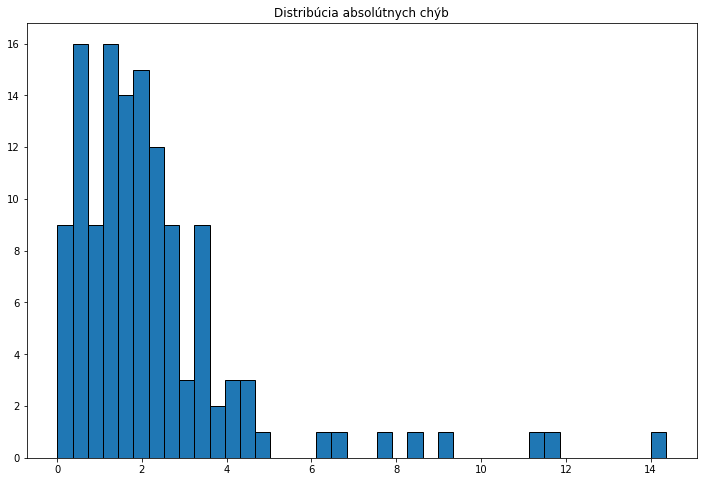

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.res_abs, bins=40, edgecolor='black')
plt.title('Distribúcia absolútnych chýb')
plt.show()


In [ ]:
pivoted.res_abs.describe()


count    129.000000
mean       2.300742
std        2.265618
min        0.008332
25%        0.987848
50%        1.818142
75%        2.816909
max       14.365432
Name: res_abs, dtype: float64

In [ ]:
##### Step 7 - Print Performance Summary

# Print the last value in the evaluation metrics contained within history file
print('-------------------- Evaluation on Training Data --------------------')
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")

# # Evaluate the model on the test data using "evaluate"
# print('-------------------- Evaluation on Test Data --------------------')
# results = lstm_model.evaluate(x_test1, y_test1)
# print("")

-------------------- Evaluation on Training Data --------------------
Final loss : 0.28504905104637146
Final mean_squared_error : 0.15814805030822754
Final mean_absolute_error : 0.28504905104637146
Final root_mean_squared_error : 0.39767831563949585
Final val_loss : 0.20233291387557983
Final val_mean_squared_error : 0.0803290531039238
Final val_mean_absolute_error : 0.20233291387557983
Final val_root_mean_squared_error : 0.2834238111972809



In [ ]:
pivote

NameError: ignored

#Sequence prediction

In [ ]:
# Number of lags (hours back) to use for models
lag = 168

# Steps ahead to forecast 
n_ahead = 24

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 20

# Batch size 
batch_size = 32

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 10

In [ ]:
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

In [ ]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

In [ ]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [ ]:
model.model.summary()


In [ ]:
history = model.train()


In [ ]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()


In [ ]:
# Forecasting on all the samples in the validation set 
forecast = model.predict(Xval)

In [ ]:
frame

In [ ]:
fig, axes = plt.subplots(
    nrows=4, 
    ncols=2, 
    figsize=(15, 15), 
    facecolor="w", 
    edgecolor="k"
)

indexes = random.sample(range(len(forecast)), 8)

for i, index in enumerate(indexes):
    
    yhat = forecast[index]
    y = Yval[index]

    frame = pd.concat([
        pd.DataFrame({'day': range(len(y)), 'temp': y, 'type': 'original'}),
        pd.DataFrame({'day': range(len(y)), 'temp': yhat, 'type': 'forecast'})
    ])
    
    frame['temp'] = [(x * train_std['T_max']) + train_mean['T_max'] for x in frame['temp']]
    
    sns.lineplot(x='day', y='temp', ax = axes[i // 2, i % 2], data=frame, hue='type', marker='o')
        
plt.tight_layout()

plt.show()


In [ ]:
# Calculating the total average absolute error 
error = 0 
n = 0
residuals = []

for i in range(Yval.shape[0]):
    true = Yval[i]
    hat = forecast[i]
    n += len(true)
    
    true = np.asarray([(x * train_std['T_max']) + train_mean['T_max'] for x in true])
    hat = np.asarray([(x * train_std['T_max']) + train_mean['T_max'] for x in hat])
    
    residual = true - hat
    residuals.append(residual)
    
    error += np.sum([abs(x) for x in true - hat]) 

print(f'Final average absolute error: {round(error / n, 2)} K')